### Evaluation code for the dataset Bla bla

Short description of metrics and panels

#### General imports

In [29]:
import pooch
import numpy as np
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt

from microsplit_reproducibility.configs.factory import (
    get_algorithm_config,
    get_likelihood_config,
    get_loss_config,
    get_model_config,
    get_optimizer_config,
    get_training_config,
    get_lr_scheduler_config,
)
from microsplit_reproducibility.utils.io import load_checkpoint
from microsplit_reproducibility.datasets import create_train_val_datasets

from careamics.lightning import VAEModule
from careamics.lvae_training.eval_utils import (
    get_predictions, get_samples, plot_error
)
from careamics.utils.metrics import avg_range_inv_psnr

#### Experiments specific imports

In [2]:
from microsplit_reproducibility.configs.parameters.pavia_p24 import get_denoisplit_parameters
from microsplit_reproducibility.configs.data.pavia_p24 import get_data_configs
from microsplit_reproducibility.datasets.pavia_p24 import get_train_val_data

### Get configs

In [3]:
train_data_config, val_data_config, test_data_configs = get_data_configs()
experiment_params = get_denoisplit_parameters()

### Create dataset

In [4]:
tmp_local_path = "/localscratch/data/pavia3_sequential_cropped"

In [5]:
DATA = pooch.create(
    # path=pooch.os_cache("microsplit_reproducibility_pavia_p24"), # TODO should be downloaded and stored locally
    path=tmp_local_path,
    base_url="",
    registry={"":""},
)

In [6]:
train_dset, val_dset, test_dset, data_stats = create_train_val_datasets(
    datapath=tmp_local_path,
    train_config=train_data_config,
    val_config=val_data_config,
    test_config=val_data_config,
    load_data_func=get_train_val_data,
)

# TODO problem is, creating a dataloader requires a config, that's ugly af


Explicit datasplit Train [1, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16]
Loaded from SubDsetType.MultiChannel /localscratch/data/pavia3_sequential_cropped 13/17 frames

Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style
MultiFileDset avg height: 1288, avg width: 1092, count: 13

Explicit datasplit Val [2, 12]
Loaded from SubDsetType.MultiChannel /localscratch/data/pavia3_sequential_cropped 2/17 frames

Padding is not used with

### Get experiment configs

In [7]:
experiment_params["data_stats"] = data_stats # TODO rethink

loss_config = get_loss_config(**experiment_params)
model_config = get_model_config(**experiment_params)
gaussian_lik_config, noise_model_config, nm_lik_config = get_likelihood_config(
    **experiment_params
)
training_config = get_training_config(**experiment_params)
lr_scheduler_config = get_lr_scheduler_config(**experiment_params)
optimizer_config = get_optimizer_config(**experiment_params)

# TODO rename to create
experiment_config = get_algorithm_config(
    algorithm=experiment_params["algorithm"],
    loss_config=loss_config,
    model_config=model_config,
    gaussian_lik_config=gaussian_lik_config,
    nm_config=noise_model_config,
    nm_lik_config=nm_lik_config,
    lr_scheduler_config=lr_scheduler_config,
    optimizer_config=optimizer_config,
)

/home/igor.zubarev/projects/careamics/src/careamics/utils/serializers.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(lst)


### Create model and load checkpoint

In [8]:
lightning_model = VAEModule(algorithm_config=experiment_config)


[GaussianMixtureNoiseModel] min_sigma: 200.0
[GaussianMixtureNoiseModel] min_sigma: 200.0
[MultiChannelNoiseModel] Nmodels count:2
[GaussianLikelihood] PredLVar:pixelwise LowBLVar:-5.0


In [9]:
ckpt = load_checkpoint("checkpoints", best=False)
lightning_model.load_state_dict(ckpt['state_dict'], strict=True)
lightning_model.eval()
lightning_model.cuda()

Loading checkpoint from: 'checkpoints/last.ckpt' - Epoch: 13


VAEModule(
  (model): LadderVAE(
    (first_bottom_up): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ELU(alpha=1.0)
      (2): BottomUpDeterministicResBlock(
        (res): ResidualBlock(
          (block): Sequential(
            (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ELU(alpha=1.0)
            (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
            (3): Dropout2d(p=0.1, inplace=False)
            (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (5): ELU(alpha=1.0)
            (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
            (7): Dropout2d(p=0.1, inplace=False)
          )
        )
      )
    )
    (lowres_first_bottom_ups): ModuleList(
      (0-1): 2 x Sequential(
        (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
        (1): ELU(alpha=1.

### Get samples from the 

Explain

In [10]:
dataset_sample, predicted_sample = get_samples(model=lightning_model, dset=test_dset, sample_idx=10)

In [11]:
dataset_sample.shape, predicted_sample.shape

((3, 64, 64), (2, 64, 64))

### Visualize samples

Text(0.5, 1.0, 'Reconstructed')

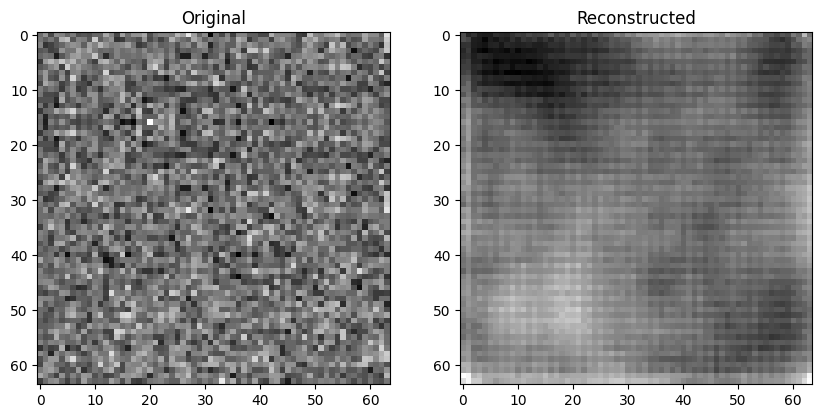

In [12]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(dataset_sample[1], cmap='gray')
ax[0].set_title("Original")
ax[1].imshow(predicted_sample[1], cmap='gray')
ax[1].set_title("Reconstructed")

### Perform evaluation

In [25]:
tiled_predictions, stitched_predictions = get_predictions(
  model=lightning_model,
  dset=test_dset,
  batch_size=experiment_params["batch_size"],
  num_workers=experiment_params["num_workers"],
  mmse_count=1,
)

Predicting patches: 100%|██████████| 43/43 [00:05<00:00,  7.63it/s]


In [30]:
file_idx = 0 # TODO dataset specific index 
target = test_dset.dsets[file_idx]._data
predictions = stitched_predictions[file_idx]

sep_mean = np.transpose(data_stats[0].numpy(), axes=(0, 2, 3, 1))
sep_std = np.transpose(data_stats[1].numpy(), axes=(0, 2, 3, 1))

target_normalized = (target - sep_mean)/ sep_std

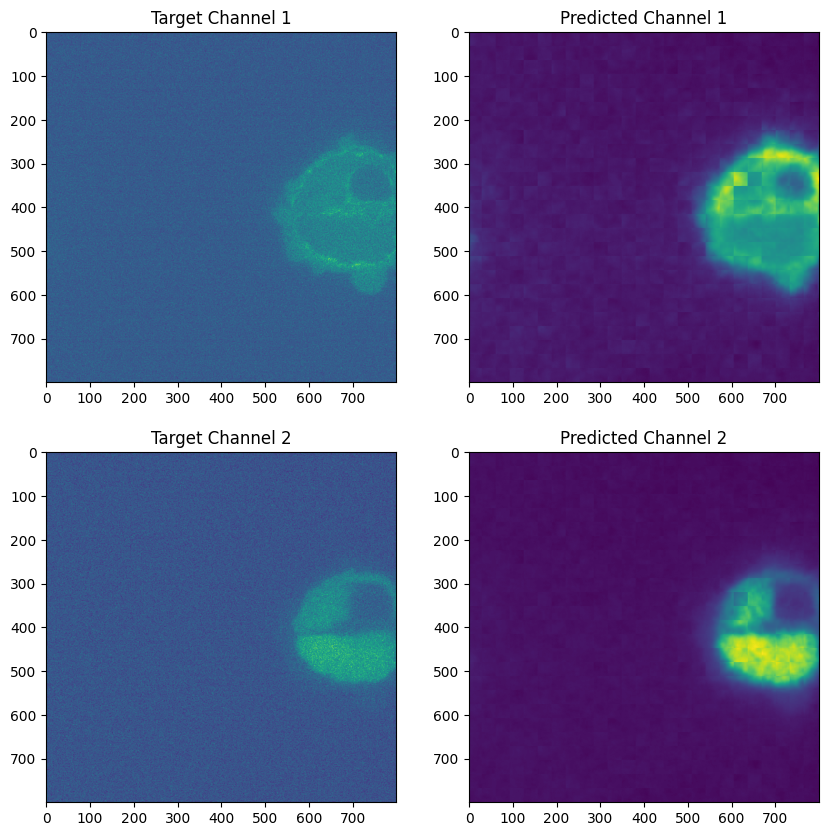

In [31]:
# One random target vs predicted image (patch of shape [sz x sz])
ncols = target.shape[-1]
_,ax = plt.subplots(figsize=(ncols*5, 2*5), nrows=2, ncols=ncols)
img_idx = 10
sz = 800
hs = np.random.randint(target.shape[1] - sz)
ws = np.random.randint(target.shape[2] - sz)
for i in range(ncols):
    ax[i,0].set_title(f'Target Channel {i+1}')
    ax[i,0].imshow(target[0, hs:hs+sz, ws:ws+sz, i])
    ax[i,1].set_title(f'Predicted Channel {i+1}')
    ax[i,1].imshow(predictions[0, hs:hs+sz, ws:ws+sz, i])

# plt.subplots_adjust(wspace=0.1, hspace=0.1)
# clean_ax(ax)

0


/home/igor.zubarev/projects/careamics/src/careamics/lvae_training/eval_utils.py:425: UserWarning: Overwriting the cmap 'shiftedcmap' that was already in the registry.
  matplotlib.colormaps.register(cmap=newcmap, force=True)


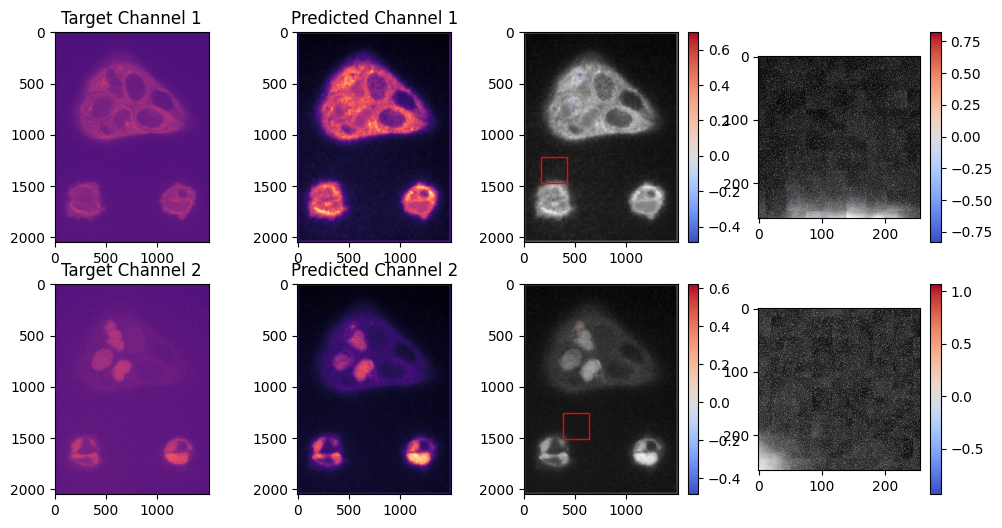

In [32]:
nrows = stitched_predictions[file_idx].shape[-1]
img_sz = 3
_,ax = plt.subplots(figsize=(4*img_sz,nrows*img_sz), ncols=4, nrows=nrows)
idx = np.random.randint(len(stitched_predictions[file_idx]))
print(idx)
for ch_id in range(nrows):
    ax[ch_id,0].set_title(f'Target Channel {ch_id+1}')
    ax[ch_id,0].imshow(target_normalized[idx,..., ch_id], cmap='magma')
    ax[ch_id,1].set_title(f'Predicted Channel {ch_id+1}')
    ax[ch_id,1].imshow(predictions[idx,:,:,ch_id], cmap='magma')
    plot_error(
        target_normalized[idx,...,ch_id],
        predictions[idx,:,:,ch_id],
        cmap = mpl.cm.coolwarm,
        ax = ax[ch_id,2],
        max_val = None
    )

    cropsz = 256
    h_s = np.random.randint(0, target_normalized.shape[1] - cropsz)
    h_e = h_s + cropsz
    w_s = np.random.randint(0, target_normalized.shape[2] - cropsz)
    w_e = w_s + cropsz

    plot_error(
        target_normalized[idx,h_s:h_e,w_s:w_e, ch_id],
        predictions[idx,h_s:h_e,w_s:w_e,ch_id],
        cmap = mpl.cm.coolwarm,
        ax = ax[ch_id,3],
        max_val = None
    )

    # Add rectangle to the region
    rect = patches.Rectangle((w_s, h_s), w_e-w_s, h_e-h_s, linewidth=1, edgecolor='r', facecolor='none')
    ax[ch_id,2].add_patch(rect)


In [ ]:
# TODO discuss visualing inidividual samples vs mmse. do both! 

### Visualize results


### Panel 1 ...